In [36]:
import Robogame as rg
import networkx as nx
import altair as alt
import time, json
import pandas as pd

import nxviz as nv
from nxviz import CircosPlot 
import matplotlib.pyplot as plt
from matplotlib import cm
import requests
from nxviz import annotate
import nx_altair as nxa
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numbers
import matplotlib.pyplot as plt
from math import pi
import streamlit as st
import seaborn as sns

To start a game server go into the server directory. Make sure you have flask and networkx installed (```conda install networkx flask flask-cors requests scipy``` should do it).

To start a server do:

```python api.py [-d directoryforgame] [-s] [-t1s T1Secret] [-t2s T2Secret] gameid```

gameid is the the prefix of all the game files (the examples we gave you are examplematch1, examplematch2, examplematch3.

```
-d/--directory is an optional directory. For example, we put the examplematch1 files in the example1 directory
-s/--simulated tells us whether to simulate team 2
-t1s/--team1secret is Team 1's secret. If you don't specify this, the server will give you one
-t2s/--team1secret is Team 2's secret. This is ignored if you use -s. If you don't specify this, the server will give you one
-m/--matchsave is a log file to save the game in, a random log name will be used if you don't specify this
```

Here's a simple game:

```python api.py -d ./example1 -s -t1s bob examplematch1```

We're using the examplematch1 files in the example1 directory, simulating player 2 and team 1's secret is 'bob' (that's us)

In [5]:
# create a game connection using bob as the "secret" key for your team (this is what you're given by the server)
game = rg.Robogame("bob")

# the default is to the localhost on port 5000, if you want something else you can do:
# game = rg.Robogame("bob",server="12.12.31.1",port=2324)

In [6]:
# tell the server we're ready to go
game.setReady()

{'Error': 'Game already started'}

In [7]:
###########Question 1###########
# How do we implement the features we discussed last time, update the producity value (Y) as we know more in the game?
predVis = st.empty()
timeVis = st.empty()
dataFrameVis = st.empty()
dataFrameVis2 = st.empty()
dataVis = st.empty()



if 'key' not in st.session_state:
    game = rg.Robogame("bob")
    game.setReady()
    st.session_state['key'] = game

else:
    game = st.session_state.key

2021-12-11 14:10:13.061 
  command:

    streamlit run /Users/dsuolang/anaconda3/envs/si649f21/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2021-12-11 14:10:13.062 Session state does not function when running a script without `streamlit run`


In [8]:
game.getGameTime()

{'curtime': 9.2,
 'gameendtime_secs': 1639250363.664348,
 'gamestarttime_secs': 1639249763.664348,
 'servertime_secs': 1639249818.849848,
 'unitsleft': 90.8}

In [10]:
# get the current game time
# there is a buffer before the game actually starts once both teams are ready

# wait for both players to be ready
while(True):
    gametime = game.getGameTime()
    timetogo = gametime['gamestarttime_secs'] - gametime['servertime_secs']
    
    if ('Error' in gametime):
        print("Error"+str(gametime))
        break
    if (timetogo <= 0):
        print("Let's go!")
        break
        
    print("waiting to launch... game will start in " + str(int(timetogo)))
    time.sleep(1) # sleep 1 second at a time, wait for the game to start
    

Let's go!


In [11]:
# check the current game time
game.getGameTime()

{'curtime': 10.38,
 'gameendtime_secs': 1639250363.664348,
 'gamestarttime_secs': 1639249763.664348,
 'servertime_secs': 1639249825.922237,
 'unitsleft': 89.62}

In [12]:
# get the robot data (note that the bets column are the guesses your team has associated with the robots at the moment)
robots = game.getRobotInfo()
# if you want this in json format, do:
# robots = game.getRobotInfo(js=True)

In [13]:
# see what's inside
robots.sample(10)

,id,name,expires,winner,Productivity,bets
125,125,Waterhauler Botski,NaN,-2,NaN,-1
147,147,Stoneminer Boterson,NaN,-2,NaN,-1
32,32,Stonehauler Botsky II,72.0,-2,NaN,-1
119,119,Rockdigger Botberg,NaN,-2,NaN,-1
74,74,Pullhauler Boterson,58.0,-2,NaN,-1
30,30,Wallwidget Botsky,25.0,-2,NaN,-1
48,48,Thumpdigger Boterson I,29.0,-2,NaN,-1
61,61,Pushhauler Botberg,73.0,-2,NaN,-1
128,128,Pullhauler Botsky Jr.,NaN,-2,NaN,-1
131,131,Stonewidget Botchik II,NaN,-2,NaN,-1


In [14]:
# we can get hints every 6 seconds or so, let's grab a few rounds of hints

# note that you can now do getHints(hintstart=4)  where the number indicates
# from when to give you the hints (so this will give you everything from time
# unit 4 until now)
for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)


# get all the hints we've collected
predHints = game.getAllPredictionHints()
partHints = game.getAllPartHints()

predhints_df = pd.read_json(json.dumps(predHints),orient='records')
parthints_df = pd.read_json(json.dumps(partHints),orient='records')
parthints_df.sample(10)

we got 72 part hints
we got 12 part hints
we got 12 part hints


,column,id,value
86,Repulsorlift Motor HP,43,-59.905262
17,Sonoreceptors,20,43.0
40,Repulsorlift Motor HP,44,99.404616
66,Polarity Sinks,23,0.871547
89,Polarity Sinks,49,0.758014
19,Repulsorlift Motor HP,44,99.404616
78,AutoTerrain Tread Count,68,1.271353
85,Astrogation Buffer Length,31,0.015477
93,Polarity Sinks,48,0.27788
50,Nanochip Model,33,windows 2000


In [15]:
# we can also tell the hacker we're interesed in the 'Astrogation Buffer Length','InfoCore Size'
#game.setPartInterest(['Astrogation Buffer Length','InfoCore Size'])

# to reset to being interested in all, use
game.setPartInterest([])

{'Result': 'OK'}

In [16]:
# if we get more hints now, they'll be biased to the robots and parts we care about

for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)

we got 252 part hints
we got 12 part hints
we got 12 part hints


In [17]:
# let's see how we're doing, grab the data
robots = game.getRobotInfo()
robots.sample(10)

,id,name,expires,winner,Productivity,bets
127,127,Pulldigger Botson,NaN,-2,NaN,-1
117,117,Firepulverizer Botberg,NaN,-2,NaN,-1
51,51,Pulldigger Boterson,28.0,2,95.475222,-1
54,54,Extralift Botberg,42.0,2,43.614280,-1
135,135,Pushpulverizer Botchik II,NaN,-2,NaN,-1
28,28,Stonewidget Botberg,77.0,-2,NaN,-1
70,70,Stoneborer Botberg Jr.,23.0,2,13.711754,-1
134,134,Excaminer Boterson I,NaN,-2,NaN,-1
94,94,Waterborer Botberg Jr.,37.0,2,56.014477,-1
61,61,Pushhauler Botberg,73.0,-2,NaN,-1


In [18]:
# let's see how we're doing, grab the data
robots = game.getRobotInfo()
robots.sample(10)

#make the part hints into a dataframe
predhints_df = pd.read_json(json.dumps(predHints),orient='records')
#parthints_df.sample(10)

# trasnform data into wide format
parthints_df_wide = parthints_df.drop_duplicates('id', keep='last')
parthints_df_wide = parthints_df_wide.pivot(index ='id', columns='column', values='value')
#parthints_df_wide.sample(10)

# link predhint data with robot data
new_data = pd.merge(robots, parthints_df_wide, left_on='id', right_on='id', how='left')

#Replace non-numric values with NA
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

new_data = new_data[new_data.applymap(isnumber)]

#Drop the rows where dependent variable are missing.
new_data = new_data.dropna(subset=['Productivity'])

#Due to large amount of missing dta, we decied to use those variables with numeric values only, and replace NAN with 0
new_data = new_data.fillna(0)

new_data.sample(10)

,id,name,expires,winner,Productivity,bets,Arakyd Vocabulator Model,Astrogation Buffer Length,AutoTerrain Tread Count,Axial Piston Model,Cranial Uplink Bandwidth,InfoCore Size,Nanochip Model,Polarity Sinks,Repulsorlift Motor HP,Sonoreceptors
57,57,0,55.0,2,12.060034,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0.0
75,75,0,31.0,2,-11.148027,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,58.0
20,20,0,41.0,2,60.940681,-1,0,0.0,0.0,0,0.0,0.0,0,0.799196,0.000000,0.0
4,4,0,28.0,2,88.397152,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0.0
42,42,0,45.0,2,42.425897,-1,0,0.0,0.0,0,25.0,0.0,0,0.000000,0.000000,0.0
51,51,0,28.0,2,95.475222,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0.0
58,58,0,58.0,2,-10.154454,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0.0
77,77,0,33.0,2,26.394635,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,0.000000,0.0
29,29,0,28.0,2,38.686413,-1,0,0.0,0.0,0,0.0,0.0,0,0.822692,0.000000,0.0
43,43,0,50.0,2,47.822306,-1,0,0.0,0.0,0,0.0,0.0,0,0.000000,-59.905262,0.0


In [52]:

x = new_data[['Astrogation Buffer Length','AutoTerrain Tread Count',
              'Cranial Uplink Bandwidth', 'InfoCore Size',
              'Polarity Sinks', 'Repulsorlift Motor HP',
              'Sonoreceptors']]
y = new_data['Productivity']

# Due to the limited amount of data, we decided not to do train test split
# Splitting the varaibles as training and testing
# X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.7,
#                                                     test_size = 0.3, random_state = 100)

# Fitting the resgression line using 'OLS'
x = sm.add_constant(x)
model = sm.OLS(y.astype(float), x.astype(float)).fit()
model.params
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Productivity   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.9086
Date:                Sat, 11 Dec 2021   Prob (F-statistic):              0.508
Time:                        14:42:02   Log-Likelihood:                -280.39
No. Observations:                  55   AIC:                             576.8
Df Residuals:                      47   BIC:                             592.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/var/folders/hq/3n5587gj1wl998b6_16rrpfm0000gn/T/ipykernel_15948/4142640523.py:34: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


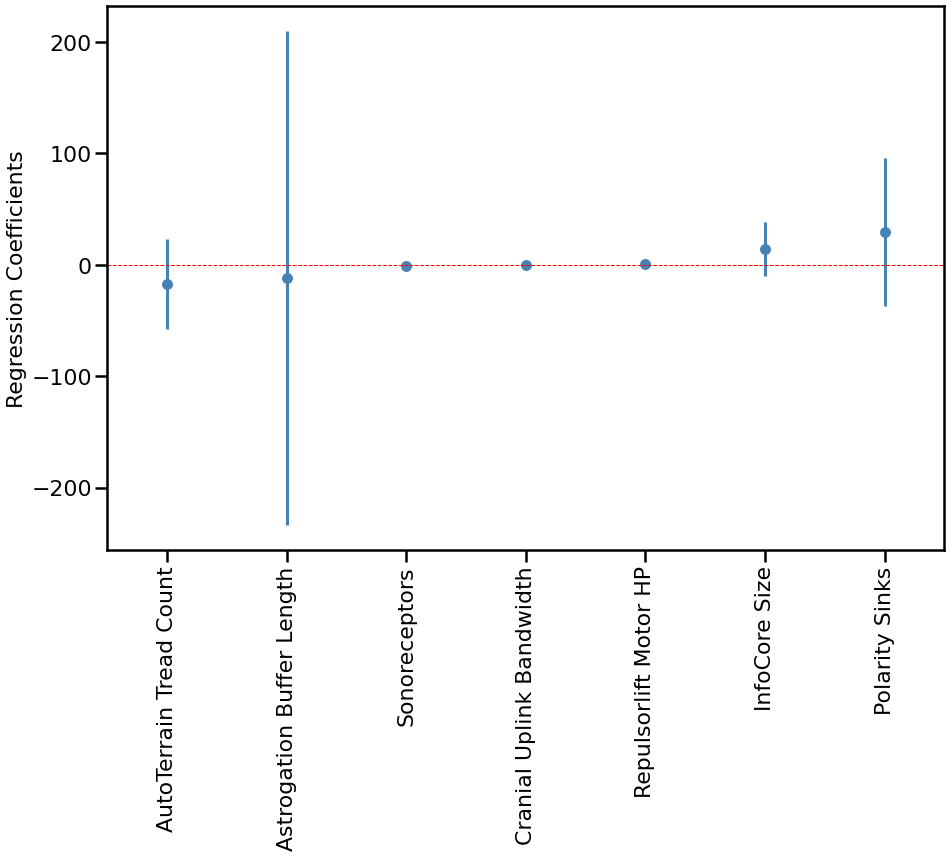

In [53]:
coef_df = pd.DataFrame(model.summary().tables[1].data)
coef_df.columns = coef_df.iloc[0]
coef_df=coef_df.drop(0)

# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])

coef_df = coef_df.astype(float)
errors = coef_df['coef'] - coef_df['[0.025']
    
coef_df['errors'] = errors

# Drop the constant for plotting
coef_df = coef_df.drop(['const'])

coef_df = coef_df.sort_values(by=['coef'])


variables = list(coef_df.index.values)
    
coef_df['variables'] = variables

sns.set_context("poster")

fig, ax = plt.subplots(figsize=(15, 10))
coef_df.plot(x='variables', y='coef', kind='bar',
             ax=ax, color='none', fontsize=22, 
             ecolor='steelblue',capsize=0,
             yerr='errors', legend=False)

ax.set_ylabel('Regression Coefficients',fontsize=22)
ax.set_xlabel('',fontsize=22)
    
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
#reference line
ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
plt.show()

In [55]:
###########Question 2###########
# We may want to show 'y_pred' value near to the above vis
# # Predict the y values corresponding to independent varibles in
# We can pass a single record to x_pred, which will be the input value of 7 (Quantitative)independent varibles we obatined from the hacker for selected robot (hacker may not provide them all) 
# How do we do that?
x_pred = 
y_pred = model.predict(x_pred)

# It need to be intergrated with the dashboard filter Daiwei designed and the streamlit

45    46.090777
48    54.199511
51    46.090777
18    43.451343
69    46.090777
79    46.090777
1     46.735120
9     46.090777
43    24.842214
99    70.964637
8     46.090777
34    46.090777
92    46.090777
29    70.097464
63    15.367621
54    46.090777
62    46.090777
dtype: float64